# Machine learning model on AF3
Created 2025-04-12

Now it is time to apply the ml models on the AF3 data

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import matplotlib as mpl

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve
import sklearn
import pickle
import re
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, auc

In [3]:
# Settings

# Path to resource folder with the structures and metadata tables
path_resources = Path(r"D:\Eigene Datein\dev\Uni\JGU Bio Bachelorthesis\Daten\resources")

path_AF2 = path_resources / "AF2"
path_AF3 = path_resources / "AF3"
path_solved = path_resources / "solved"

In [4]:
dataAF2 = pd.read_csv(path_AF2 / "AF2_metrics.tsv", sep="\t")
# Old metrics
# dataAF2 = pd.read_csv(path_AF2 / "John metrics" / "AF_metrics_all_structures.tsv", sep="\t")
for c in ["chainA_start", "chainA_end", "chainB_start", "chainB_end", "num_mutations", "num_align_atoms_domain", "num_align_resi_domain", "hbonds", "salt_bridges", "hydrophobic_interactions"]:
    if c not in dataAF2.columns:
        print(f"Column {bcolors.FAIL}{c}{bcolors.ENDC} not (yet) in data frame")
        continue
    dataAF2[c] = dataAF2[c].astype(pd.Int64Dtype())
display(dataAF2)

,project_name,run_id,benchmark_set,prediction_name,model_id,chainA_length,chainB_length,chainA_id,chainB_id,chainA_start,...,RMSD_all_atom,DockQ,iRMSD,LRMSD,Fnonnat,buried_area,min_distance,salt_bridges,hbonds,hydrophobic_interactions
0,AlphaFold_benchmark,run37,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_0,312,5,A,B,165,...,0.976244,0.878344,0.603831,1.575394,0.086957,662.104,6.072,0,10,3
1,AlphaFold_benchmark,run37,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_1,312,5,A,B,165,...,0.979658,0.880716,0.418230,1.100588,0.050000,613.651,6.063,0,9,0
2,AlphaFold_benchmark,run37,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_2,312,5,A,B,165,...,0.969753,0.883186,0.641834,1.776257,0.185185,323.304,5.092,0,2,9
3,AlphaFold_benchmark,run37,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_3,312,5,A,B,165,...,1.260424,0.475511,1.686332,5.358800,0.363636,853.680,5.658,11,12,6
4,AlphaFold_benchmark,run37,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_4,312,5,A,B,165,...,1.759591,0.223400,2.928606,9.908745,0.888889,851.771,5.691,9,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,AlphaFold_benchmark_DDI,run6,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0,60,113,B,B,392,...,5.341712,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
3176,AlphaFold_benchmark_DDI,run6,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1,60,113,B,B,392,...,5.975135,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
3177,AlphaFold_benchmark_DDI,run6,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2,60,113,B,B,392,...,5.962444,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>
3178,AlphaFold_benchmark_DDI,run6,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3,60,113,B,B,392,...,5.901696,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>


In [5]:
dataAF3 = pd.read_csv(path_AF3 / "AF3_metrics.tsv", sep="\t")
for c in ["chainA_start", "chainA_end", "chainB_start", "chainB_end", "num_mutations", "num_align_atoms_domain", "num_align_resi_domain", "hbonds", "salt_bridges", "hydrophobic_interactions"]:
    if c not in dataAF3.columns:
        print(f"Column {bcolors.FAIL}{c}{bcolors.ENDC} not (yet) in data frame")
        continue
    dataAF3[c] = dataAF3[c].astype(pd.Int64Dtype())
display(dataAF3)

,model_preset,benchmark_set,prediction_name,model_id,ranking_score,chainA_length,chainB_length,chainA_id,chainB_id,chainA_start,...,DockQ,iRMSD,LRMSD,Fnonnat,buried_area,min_distance,salt_bridges,hbonds,hydrophobic_interactions,ipSAE
0,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_0,0.97,312,5,A,B,165,...,0.967617,0.341276,0.831159,0.000000,848.152,5.371,9,0,6,0.869025
1,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_1,0.97,312,5,A,B,165,...,0.943274,0.426121,1.169542,0.076923,603.522,6.264,0,0,0,0.868551
2,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_2,0.96,312,5,A,B,165,...,0.908970,0.621263,1.944753,0.111111,602.041,6.241,0,0,0,0.855837
3,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_3,0.96,312,5,A,B,165,...,0.961964,0.382246,1.037074,0.038462,615.163,6.207,0,0,0,0.850758
4,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_4,0.96,312,5,A,B,165,...,0.931179,0.573091,1.749101,0.074074,662.502,5.890,0,0,0,0.850449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0,0.36,60,113,B,B,392,...,NaN,NaN,NaN,NaN,1447.877,4.251,1,0,19,0.012324
3176,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1,0.23,60,113,B,B,392,...,NaN,NaN,NaN,NaN,1482.311,4.197,1,0,25,0.000000
3177,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2,0.22,60,113,B,B,392,...,NaN,NaN,NaN,NaN,1564.435,4.783,2,0,18,0.000000
3178,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3,0.21,60,113,B,B,392,...,NaN,NaN,NaN,NaN,1431.933,4.257,0,0,59,0.000000


In [76]:
dataAF = pd.merge(
    left=dataAF3,
    right=dataAF2,
    left_on=["prediction_name", "model_id"],
    right_on=["prediction_name", "model_id"],
    suffixes=["_AF3", "_AF2"],
    how="inner"
)
for c in ["benchmark_set", "chainA_length", "chainB_length", "chainA_id", "chainB_id", "chainA_start", "chainA_end", "chainB_start", "chainB_end", "PDB_id", "ELM_instance", "DDI_pfam_id", "PDB_id_random_paired", "ELM_instance_random_paired", "DDI_pfam_id_random_paired", "sequence_initial", "sequence_mutated", "num_mutations"]:
    if len(dataAF[~(dataAF[c+"_AF2"] == dataAF[c+"_AF3"]) & (~dataAF[c+"_AF2"].isna()) & (~dataAF[c+"_AF3"].isna())]) > 0:
        print(f"Unmatched column {c}")
        continue
    dataAF.drop(columns=[c+"_AF2"], inplace=True)
    dataAF.rename(columns={c+"_AF3": c}, inplace=True)
dataAF["min_distance_AF2"] = dataAF["min_distance_AF2"].fillna(np.max(dataAF["min_distance_AF2"]))
dataAF["min_distance_AF3"] = dataAF["min_distance_AF3"].fillna(np.max(dataAF["min_distance_AF3"]))
display(dataAF)

,model_preset,benchmark_set,prediction_name,model_id,ranking_score,chainA_length,chainB_length,chainA_id,chainB_id,chainA_start,...,RMSD_all_atom_AF2,DockQ_AF2,iRMSD_AF2,LRMSD_AF2,Fnonnat_AF2,buried_area_AF2,min_distance_AF2,salt_bridges_AF2,hbonds_AF2,hydrophobic_interactions_AF2
0,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_0,0.97,312,5,A,B,165,...,0.976244,0.878344,0.603831,1.575394,0.086957,662.104,6.072,0,10,3
1,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_1,0.97,312,5,A,B,165,...,0.979658,0.880716,0.418230,1.100588,0.050000,613.651,6.063,0,9,0
2,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_2,0.96,312,5,A,B,165,...,0.969753,0.883186,0.641834,1.776257,0.185185,323.304,5.092,0,2,9
3,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_3,0.96,312,5,A,B,165,...,1.260424,0.475511,1.686332,5.358800,0.363636,853.680,5.658,11,12,6
4,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_4,0.96,312,5,A,B,165,...,1.759591,0.223400,2.928606,9.908745,0.888889,851.771,5.691,9,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0,0.36,60,113,B,B,392,...,5.341712,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3166,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1,0.23,60,113,B,B,392,...,5.975135,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3167,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2,0.22,60,113,B,B,392,...,5.962444,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3168,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3,0.21,60,113,B,B,392,...,5.901696,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>


In [38]:
X_columns = ["chainA_intf_avg_plddt", "chainB_intf_avg_plddt", "intf_avg_plddt", "pDockQ", "iPAE", 
            "buried_area", "min_distance", "hbonds", "salt_bridges", "hydrophobic_interactions"]
X2_columns = ["chainA_length", "chainB_length"]
X_intf_metrics_columns = ["num_chainA_intf_res", "num_chainB_intf_res", "num_res_res_contact", "buried_area", "min_distance", "hbonds", "salt_bridges", "hydrophobic_interactions"]
X_AF2_columns = ["model_confidence"] + [x+"_AF2" for x in X_columns] + X2_columns
X_AF2_columns_metrics = [x+"_AF2" for x in X_intf_metrics_columns] + X2_columns
X_AF3_columns = ["ranking_score"]+ [x+"_AF3" for x in X_columns] + X2_columns
X_AF3_columns_metrics = [x+"_AF3" for x in X_intf_metrics_columns] + X2_columns

## 1 RMSD prediction

#### 1a known DMI RMSD prediction

LinearRegression()

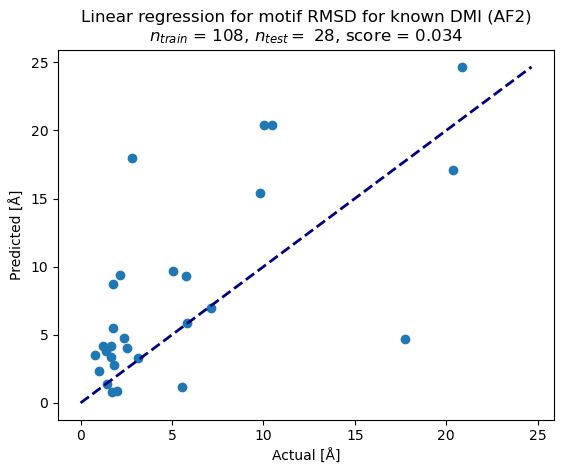

In [9]:
dataAF_knownDMI = dataAF[(dataAF["benchmark_set"] == "known_DMI") & (dataAF["model_id"] == "ranked_0") & (~dataAF["RMSD_all_atom_peptide_AF2"].isna())]
knownDMI_xtrain, knownDMI_xtest, knownDMI_ytrain, knownDMI_ytest = train_test_split(dataAF_knownDMI[X_AF2_columns], dataAF_knownDMI["RMSD_all_atom_peptide_AF2"], test_size=0.2, random_state=2501)

reg = LinearRegression().fit(knownDMI_xtrain, knownDMI_ytrain)
display(reg)

y_pred = reg.predict(knownDMI_xtest)
score = reg.score(knownDMI_xtest, knownDMI_ytest)
plt.scatter(knownDMI_ytest, y_pred)
plt.plot([0, np.max([knownDMI_ytest, y_pred])], [0, np.max([knownDMI_ytest, y_pred])], color='navy', lw=2, linestyle='--')

plt.title("Linear regression for motif RMSD for known DMI (AF2)\n$n_{train}$ = %i, $n_{test}=$ %i, score = %0.3f" % (len(knownDMI_xtrain), len(knownDMI_xtest), score))
plt.ylabel("Predicted [Å]")
plt.xlabel("Actual [Å]")
plt.show()

LinearRegression()

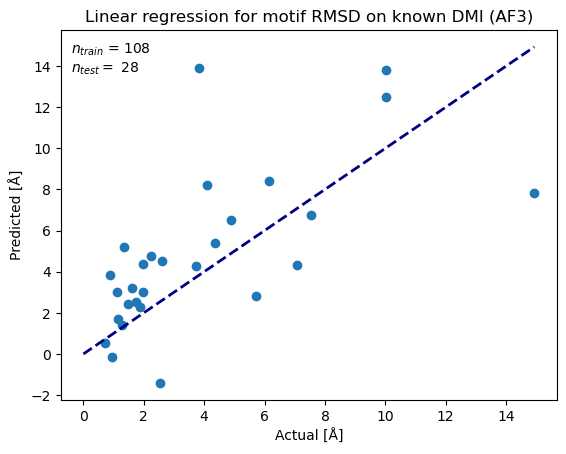

In [19]:
dataAF_knownDMI = dataAF[(dataAF["benchmark_set"] == "known_DMI") & (dataAF["model_id"] == "ranked_0") & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]
knownDMI_xtrain, knownDMI_xtest, knownDMI_ytrain, knownDMI_ytest = train_test_split(dataAF_knownDMI[X_AF3_columns], dataAF_knownDMI["RMSD_all_atom_peptide_AF3"], test_size=0.2, random_state=2501)

reg = LinearRegression().fit(knownDMI_xtrain, knownDMI_ytrain)
display(reg)

y_pred = reg.predict(knownDMI_xtest)
score = reg.score(knownDMI_xtest, knownDMI_ytest)
plt.scatter(knownDMI_ytest, y_pred)
plt.plot([0, np.max([knownDMI_ytest, y_pred])], [0, np.max([knownDMI_ytest, y_pred])], color='navy', lw=2, linestyle='--')
plt.title("Linear regression for motif RMSD on known DMI (AF3)")
plt.text(0.02,0.97, "$n_{train}$ = %i\n$n_{test}=$ %i" % (len(knownDMI_xtrain), len(knownDMI_xtest)), transform = plt.gca().transAxes, verticalalignment="top", fontsize=10)
#plt.title("Linear regression for motif RMSD for known DMI (AF3)\n$n_{train}$ = %i, $n_{test}=$ %i, score = %0.3f" % (len(knownDMI_xtrain), len(knownDMI_xtest), score))
plt.ylabel("Predicted [Å]")
plt.xlabel("Actual [Å]")
plt.savefig("export.svg")
plt.show()

#### 1b Selection based on structure names

LinearRegression()

-0.5870157429622782


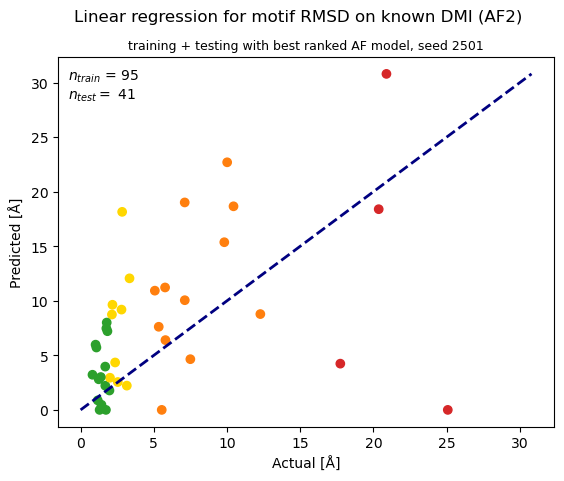

In [69]:
structure_names = sorted(list(set(dataAF[(dataAF["benchmark_set"] == "known_DMI") & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["prediction_name"])))
structures_train, structures_test = train_test_split(structure_names, test_size=0.3, random_state=(seed := 2501))
x_columns = ["model_confidence"]
x_columns = X_AF2_columns
knownDMI_xtrain = dataAF[dataAF["prediction_name"].isin(structures_train)& (dataAF["model_id"] == "ranked_0")][x_columns]
knownDMI_ytrain = dataAF[dataAF["prediction_name"].isin(structures_train)& (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF2"]
knownDMI_xtest = dataAF[dataAF["prediction_name"].isin(structures_test) & (dataAF["model_id"] == "ranked_0")][x_columns]
knownDMI_ytest = dataAF[dataAF["prediction_name"].isin(structures_test) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF2"]

reg = LinearRegression().fit(knownDMI_xtrain, knownDMI_ytrain)
display(reg)

x, y = knownDMI_xtest, knownDMI_ytest
y_pred = reg.predict(x)
y_pred = np.clip(y_pred, a_min=0, a_max=None)
colors = ["red", "tab:red", "tab:orange", "gold", "tab:green"]
c = [colors[sum(y<=cutoff for cutoff in [2, 5, 15, np.inf])] for y in y]

score = reg.score(x, y)
print(score)
plt.scatter(y, y_pred, c=c)
plt_range = (0, np.nanmax([y, y_pred])) 
#plt_range = (0, 50)
plt.plot(plt_range, plt_range, color='navy', lw=2, linestyle='--')
plt.ylabel("Predicted [Å]")
plt.xlabel("Actual [Å]")
plt.suptitle("Linear regression for motif RMSD on known DMI (AF2)")
#plt.title(f"training with 5 AF models per structure, test with best ranked, seed {seed}", fontsize=9)
#plt.title(f"training with best ranked AF model, testing with 5 per structure, seed {seed}", fontsize=9)
plt.title(f"training + testing with best ranked AF model, seed {seed}", fontsize=9)
#plt.title(f"training + testing with 5 AF models per structure, seed {seed}", fontsize=9)
plt.text(0.02,0.97, "$n_{train}$ = %i\n$n_{test}=$ %i" % (len(knownDMI_xtrain), len(knownDMI_xtest)), transform = plt.gca().transAxes, verticalalignment="top", fontsize=10)
#plt.xlim(plt_range)
#plt.ylim(plt_range)
#plt.savefig("export.svg")
plt.show()

LinearRegression()

0.15520918810324125


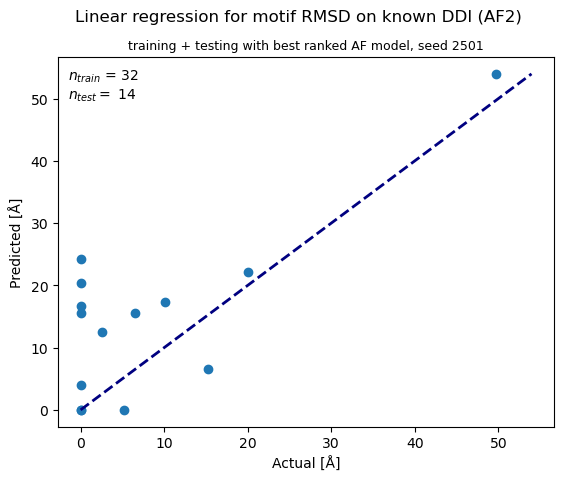

In [62]:
# DDIs
structure_names = sorted(list(set(dataAF[(dataAF["benchmark_set"] == "known_DDI") & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["prediction_name"])))
structures_train, structures_test = train_test_split(structure_names, test_size=0.3, random_state=(seed := 2501))
x_columns = ["model_confidence"]
x_columns = X_AF2_columns
knownDMI_xtrain = dataAF[dataAF["prediction_name"].isin(structures_train)& (dataAF["model_id"] == "ranked_0")][x_columns]
knownDMI_ytrain = dataAF[dataAF["prediction_name"].isin(structures_train)& (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF2"]
knownDMI_xtest = dataAF[dataAF["prediction_name"].isin(structures_test) & (dataAF["model_id"] == "ranked_0")][x_columns]
knownDMI_ytest = dataAF[dataAF["prediction_name"].isin(structures_test) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF2"]

reg = LinearRegression().fit(knownDMI_xtrain, knownDMI_ytrain)
display(reg)

x, y = knownDMI_xtest, knownDMI_ytest
y_pred = reg.predict(x)
y_pred = np.clip(y_pred, a_min=0, a_max=None)
colors = ["red", "tab:red", "tab:orange", "gold", "tab:green"]
c = [colors[sum(y<=cutoff for cutoff in [2, 5, 15, np.inf])] for y in y]

score = reg.score(x, y)
print(score)
plt.scatter(y, y_pred)
plt_range = (0, np.nanmax([y, y_pred])) 
#plt_range = (0, 50)
plt.plot(plt_range, plt_range, color='navy', lw=2, linestyle='--')
plt.ylabel("Predicted [Å]")
plt.xlabel("Actual [Å]")
plt.suptitle("Linear regression for motif RMSD on known DDI (AF2)")
#plt.title(f"training with 5 AF models per structure, test with best ranked, seed {seed}", fontsize=9)
#plt.title(f"training with best ranked AF model, testing with 5 per structure, seed {seed}", fontsize=9)
plt.title(f"training + testing with best ranked AF model, seed {seed}", fontsize=9)
#plt.title(f"training + testing with 5 AF models per structure, seed {seed}", fontsize=9)
plt.text(0.02,0.97, "$n_{train}$ = %i\n$n_{test}=$ %i" % (len(knownDMI_xtrain), len(knownDMI_xtest)), transform = plt.gca().transAxes, verticalalignment="top", fontsize=10)
#plt.xlim(plt_range)
#plt.ylim(plt_range)
#plt.savefig("export.svg")
plt.show()

LinearRegression()

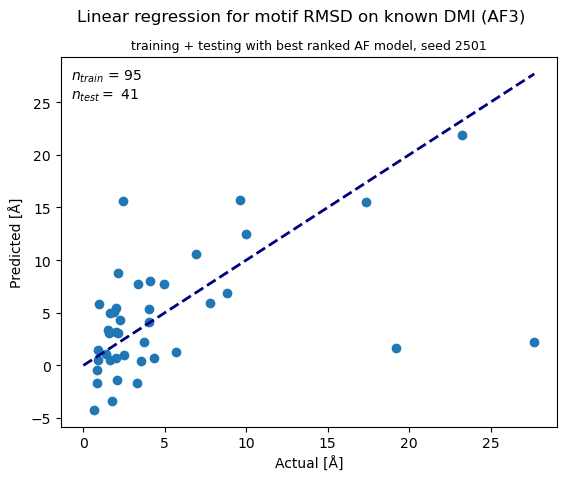

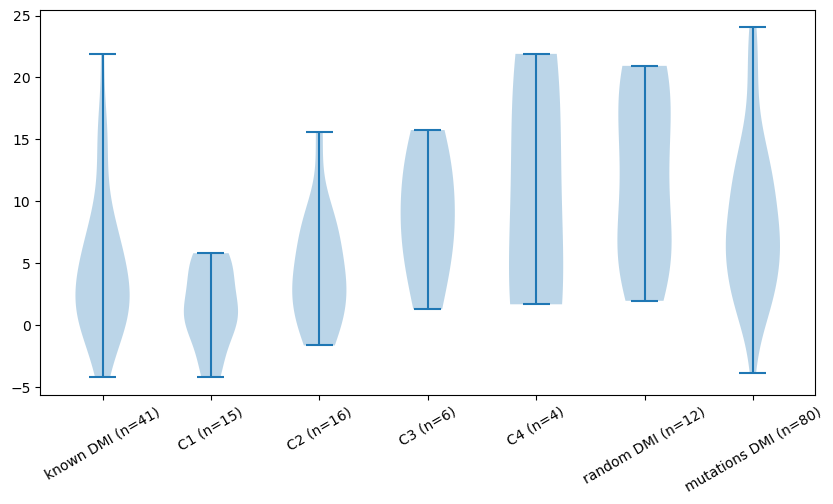

In [ ]:
pdb_ids = sorted(list(set(dataAF[(dataAF["benchmark_set"].isin(["known_DMI"])) & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["PDB_id"])))
pdb_ids_train, pdb_ids_test = train_test_split(pdb_ids, test_size=0.3, random_state=(seed := 2501))
knownDMI_xtrain = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_train) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_ytrain = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_train) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF3"]
knownDMI_xtest = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_ytest = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF3"]


reg = LinearRegression().fit(knownDMI_xtrain, knownDMI_ytrain)
display(reg)

x, y = knownDMI_xtest, knownDMI_ytest
colors = ["red", "tab:green", "gold", "tab:orange", "tab:red"]
c = [colors[sum(y<=cutoff for cutoff in [2, 5, 15, np.inf])] for y in y]
y_pred = reg.predict(x)

score = reg.score(x, y)
plt.scatter(y, y_pred)
plt_range = (0, np.nanmax([y, y_pred])) 
plt.plot(plt_range, plt_range, color='navy', lw=2, linestyle='--')
plt.ylabel("Predicted [Å]")
plt.xlabel("Actual [Å]")
plt.suptitle("Linear regression for motif RMSD on known DMI (AF3)")
#plt.title(f"training with 5 AF models per structure, test with best ranked, seed {seed}", fontsize=9)
#plt.title(f"training with best ranked AF model, testing with 5 per structure, seed {seed}", fontsize=9)
plt.title(f"training + testing with best ranked AF model, seed {seed}", fontsize=9)
#plt.title(f"training + testing with 5 AF models per structure, seed {seed}", fontsize=9)
plt.text(0.02,0.97, "$n_{train}$ = %i\n$n_{test}=$ %i" % (len(knownDMI_xtrain), len(knownDMI_xtest)), transform = plt.gca().transAxes, verticalalignment="top", fontsize=10)
#plt.xlim(plt_range)
#plt.ylim(plt_range)
#plt.savefig("export.svg")
plt.show()

plt.figure(figsize=(10,5))
knownDMI_xtest_c1 = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["RMSD_all_atom_peptide_AF3"] <= 2) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_xtest_c2 = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["RMSD_all_atom_peptide_AF3"] > 2) & (dataAF["RMSD_all_atom_peptide_AF3"] <= 5) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_xtest_c3 = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["RMSD_all_atom_peptide_AF3"] > 5) & (dataAF["RMSD_all_atom_peptide_AF3"] <= 15) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_xtest_c4 = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["RMSD_all_atom_peptide_AF3"] > 15) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]

knownDMI_xtest_random = dataAF[(dataAF["benchmark_set"] == "random_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (~dataAF["PDB_id_random_paired"].isin(pdb_ids_train)) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_xtest_mutations = dataAF[(dataAF["benchmark_set"] == "mutations_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
y_pred_c1 = reg.predict(knownDMI_xtest_c1)
y_pred_c2 = reg.predict(knownDMI_xtest_c2)
y_pred_c3 = reg.predict(knownDMI_xtest_c3)
y_pred_c4 = reg.predict(knownDMI_xtest_c4)
y_pred_random = reg.predict(knownDMI_xtest_random)
y_pred_mutations = reg.predict(knownDMI_xtest_mutations)
plt.violinplot([y_pred, y_pred_c1, y_pred_c2, y_pred_c3, y_pred_c4, y_pred_random, y_pred_mutations], positions=range(1,8))
plt.xticks(range(1,8), [f"known DMI (n={len(y_pred)})", f"C1 (n={len(y_pred_c1)})",  f"C2 (n={len(y_pred_c2)})", f"C3 (n={len(y_pred_c3)})", f"C4 (n={len(y_pred_c4)})",
                        f"random DMI (n={len(y_pred_random)})", f"mutations DMI (n={len(y_pred_mutations)})"], rotation=30)
plt.show()

#### 1c RMSD prediction on whole dataset

Lasso(alpha=0.5)

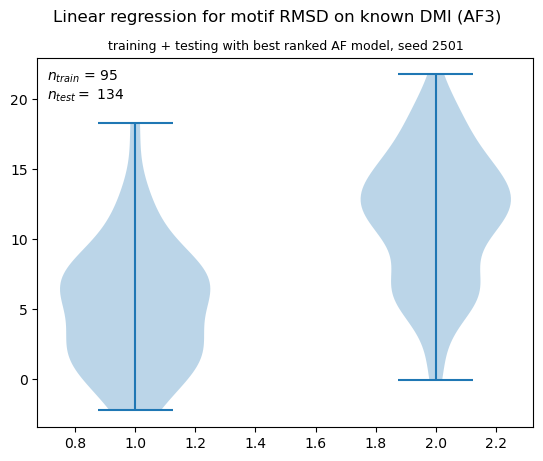

In [16]:
# Testing on the whole dataset

structure_names = list(set(dataAF[(dataAF["benchmark_set"] == "known_DMI") & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["prediction_name"]))
structures_train, structures_test = train_test_split(structure_names, test_size=0.3, random_state=(seed := 2501))
knownDMI_xtrain = dataAF[dataAF["prediction_name"].isin(structures_train) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_ytrain = dataAF[dataAF["prediction_name"].isin(structures_train) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF3"]
knownDMI_xtest = dataAF[dataAF["prediction_name"].isin(structures_test) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_ytest = dataAF[dataAF["prediction_name"].isin(structures_test) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF3"]


reg = Lasso(alpha=0.5).fit(knownDMI_xtrain, knownDMI_ytrain)
display(reg)

x, y = knownDMI_xtest, knownDMI_ytest
y_pred_1 = reg.predict(x)
knownDMI_xtest = dataAF[(dataAF["benchmark_set"] == "random_DMI") & (dataAF["model_id"] == "ranked_0") & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())][X_AF3_columns]
y_pred_2 = reg.predict(knownDMI_xtest)

plt.violinplot([y_pred_1, y_pred_2])
plt.suptitle("Linear regression for motif RMSD on known DMI (AF3)")
#plt.title(f"training with 5 AF models per structure, test with best ranked, seed {seed}", fontsize=9)
#plt.title(f"training with best ranked AF model, testing with 5 per structure, seed {seed}", fontsize=9)
plt.title(f"training + testing with best ranked AF model, seed {seed}", fontsize=9)
#plt.title(f"training + testing with 5 AF models per structure, seed {seed}", fontsize=9)
plt.text(0.02,0.97, "$n_{train}$ = %i\n$n_{test}=$ %i" % (len(knownDMI_xtrain), len(knownDMI_xtest)), transform = plt.gca().transAxes, verticalalignment="top", fontsize=10)
#plt.xlim(plt_range)
#plt.ylim(plt_range)
#plt.savefig("export.svg")
plt.show()

LinearRegression()

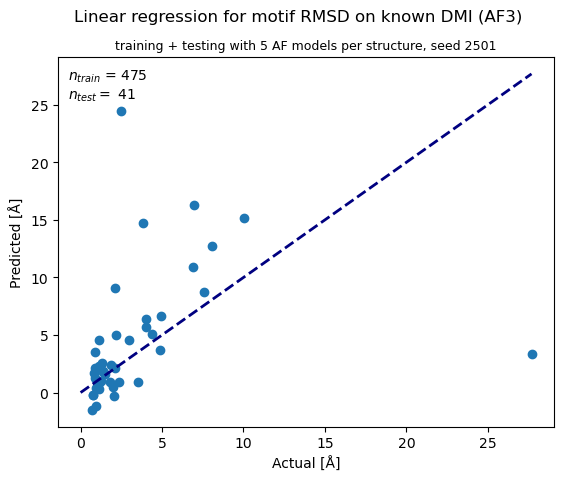

In [35]:
structure_names = list(set(dataAF[(dataAF["benchmark_set"] == "known_DMI") & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["prediction_name"]))
structures_train, structures_test = train_test_split(structure_names, test_size=0.3, random_state=2505)
knownDMI_xtrain = dataAF[dataAF["prediction_name"].isin(structures_train)][X_AF3_columns]
knownDMI_ytrain = dataAF[dataAF["prediction_name"].isin(structures_train)]["RMSD_all_atom_peptide_AF3"]
knownDMI_xtest = dataAF[dataAF["prediction_name"].isin(structures_test) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_ytest = dataAF[dataAF["prediction_name"].isin(structures_test) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF3"]

reg = LinearRegression().fit(knownDMI_xtrain, knownDMI_ytrain)
display(reg)

y_pred = reg.predict(knownDMI_xtest)
score = reg.score(knownDMI_xtest, knownDMI_ytest)
plt.scatter(knownDMI_ytest, y_pred)
plt_range = (0, np.max([knownDMI_ytest, y_pred])) 
plt.plot(plt_range, plt_range, color='navy', lw=2, linestyle='--')
plt.ylabel("Predicted [Å]")
plt.xlabel("Actual [Å]")
plt.suptitle("Linear regression for motif RMSD on known DMI (AF3)")
#plt.title("training with 5 AF models per structure, test with best ranked", fontsize=9)
#plt.title("training with 5 AF models per structure, test with best ranked", fontsize=9)
#plt.title("training with 5 AF models per structure, test with best ranked", fontsize=9)
plt.title("training + testing with 5 AF models per structure, seed 2501", fontsize=9)
plt.text(0.02,0.97, "$n_{train}$ = %i\n$n_{test}=$ %i" % (len(knownDMI_xtrain), len(knownDMI_xtest)), transform = plt.gca().transAxes, verticalalignment="top", fontsize=10)
#plt.xlim(plt_range)
#plt.ylim(plt_range)
plt.savefig("export.svg")
plt.show()

#### 1d Lasso regression

In [ ]:
from sklearn.linear_model import LassoCV


structure_names = list(set(dataAF[(dataAF["benchmark_set"] == "known_DMI") & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["prediction_name"]))
structures_train, structures_test = train_test_split(structure_names, test_size=0.3, random_state=(seed := 2501))
knownDMI_xtrain = dataAF[dataAF["prediction_name"].isin(structures_train)][X_AF3_columns]
knownDMI_ytrain = dataAF[dataAF["prediction_name"].isin(structures_train)]["RMSD_all_atom_peptide_AF3"]
knownDMI_xtest = dataAF[dataAF["prediction_name"].isin(structures_test) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_ytest = dataAF[dataAF["prediction_name"].isin(structures_test) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF3"]


l = LassoCV(random_state=2501).fit(knownDMI_xtrain, knownDMI_ytrain)
display(reg)

x, y = knownDMI_xtest, knownDMI_ytest
y_pred = reg.predict(x)

score = reg.score(x, y)
plt.scatter(y, y_pred)
plt_range = (0, np.nanmax([y, y_pred])) 
plt.plot(plt_range, plt_range, color='navy', lw=2, linestyle='--')
plt.ylabel("Predicted [Å]")
plt.xlabel("Actual [Å]")
plt.suptitle("Linear regression for motif RMSD on known DMI (AF3)")
#plt.title(f"training with 5 AF models per structure, test with best ranked, seed {seed}", fontsize=9)
#plt.title(f"training with best ranked AF model, testing with 5 per structure, seed {seed}", fontsize=9)
plt.title(f"training + testing with best ranked AF model, seed {seed}", fontsize=9)
#plt.title(f"training + testing with 5 AF models per structure, seed {seed}", fontsize=9)
plt.text(0.02,0.97, "$n_{train}$ = %i\n$n_{test}=$ %i" % (len(knownDMI_xtrain), len(knownDMI_xtest)), transform = plt.gca().transAxes, verticalalignment="top", fontsize=10)
#plt.xlim(plt_range)
#plt.ylim(plt_range)
#plt.savefig("export.svg")
plt.show()

#### 1d class prediction

LinearRegression()

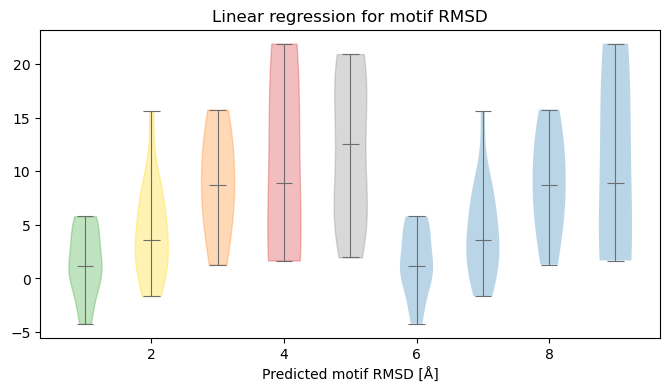

In [12]:
pdb_ids = sorted(list(set(dataAF[(dataAF["benchmark_set"].isin(["known_DMI"])) & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["PDB_id"])))
pdb_ids_train, pdb_ids_test = train_test_split(pdb_ids, test_size=0.3, random_state=(seed := 2501))
knownDMI_xtrain = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_train) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_ytrain = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_train) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF3"]
knownDMI_xtest = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_ytest = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF3"]


reg = LinearRegression().fit(knownDMI_xtrain, knownDMI_ytrain)
display(reg)

classes = {
    "Correct sidechain": (-np.inf, 2), 
    "Correct backbone": (2, 5), 
    "Correct pocket": (5, 15), 
    "Wrong pocket": (15, np.inf),
}
datasets = {}
y_preds = {}

for cl, (b_lower, b_upper) in classes.items():
    cl = cl + "(known motif)"
    datasets[cl] = dataAF[(dataAF["benchmark_set"].isin(["known_DMI"])) & dataAF["PDB_id"].isin(pdb_ids_test) 
                    & ((dataAF["PDB_id_random_paired"].isna()) | (~dataAF["PDB_id_random_paired"].isin(pdb_ids_train)))
                    & (dataAF["RMSD_all_atom_peptide_AF3"] > b_lower) & (dataAF["RMSD_all_atom_peptide_AF3"] <= b_upper) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
    y_preds[cl] = reg.predict(datasets[cl])

datasets["Randomly paired"] = dataAF[(dataAF["benchmark_set"] == "random_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) 
                & ((dataAF["PDB_id_random_paired"].isna()) | (~dataAF["PDB_id_random_paired"].isin(pdb_ids_train)))
                & dataAF["RMSD_all_atom_peptide_AF3"].isna() & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
y_preds["Randomly paired"] = reg.predict(datasets["Randomly paired"])

for cl, (b_lower, b_upper) in classes.items():
    cl = cl + "(mutated motif)"
    datasets[cl] = dataAF[(dataAF["benchmark_set"].isin(["known_DMI"])) & dataAF["PDB_id"].isin(pdb_ids_test) 
                    & ((dataAF["PDB_id_random_paired"].isna()) | (~dataAF["PDB_id_random_paired"].isin(pdb_ids_train)))
                    & (dataAF["RMSD_all_atom_peptide_AF3"] > b_lower) & (dataAF["RMSD_all_atom_peptide_AF3"] <= b_upper) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
    y_preds[cl] = reg.predict(datasets[cl])

plt.figure(figsize=(8,4))
plt_vl = plt.violinplot([v for v in y_preds.values()], range(1,1+len(y_preds)), showextrema=True, showmedians=True)
plt_vl['bodies'][0].set_color("tab:green")
plt_vl['bodies'][1].set_color("gold")
plt_vl['bodies'][2].set_color("tab:orange")
plt_vl['bodies'][3].set_color("tab:red")
plt_vl['bodies'][4].set_color("tab:gray")

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = plt_vl[partname]
    vp.set_edgecolor("#6e6d6d")
    vp.set_linewidth(0.8)

#plt.xticks(range(1,1+len(y_preds)), [f"{k}\n(n={len(v)})" for k,v in datasets.items()])
plt.xlabel("Predicted motif RMSD [Å]")
plt.title("Linear regression for motif RMSD")
plt.show()

Training set: 475


LinearRegression()

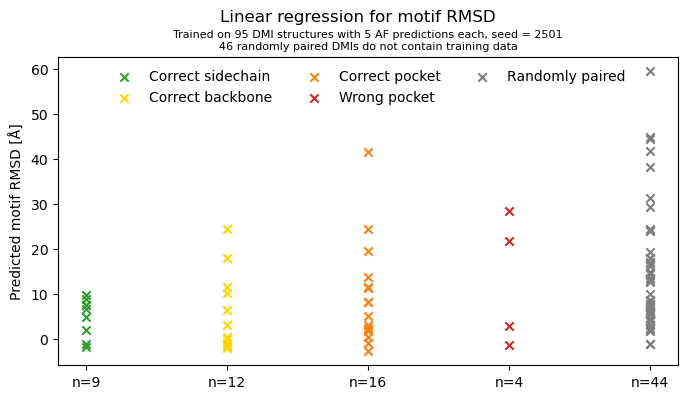

In [68]:
pdb_ids = sorted(list(set(dataAF[(dataAF["benchmark_set"].isin(["known_DMI"])) & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["PDB_id"])))
pdb_ids_train, pdb_ids_test = train_test_split(pdb_ids, test_size=0.3, random_state=(seed := 2501))
knownDMI_xtrain = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_train) ][X_AF2_columns]
knownDMI_ytrain = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_train)]["RMSD_all_atom_peptide_AF2"]

print("Training set:", len(knownDMI_xtrain))

reg = LinearRegression().fit(knownDMI_xtrain, knownDMI_ytrain)
display(reg)

classes = {
    "Correct sidechain": (-np.inf, 2), 
    "Correct backbone": (2, 5), 
    "Correct pocket": (5, 15), 
    "Wrong pocket": (15, np.inf),
}
datasets = {}
y_preds = {}

for cl, (b_lower, b_upper) in classes.items():
    datasets[cl] = dataAF[(dataAF["benchmark_set"].isin(["known_DMI"])) & dataAF["PDB_id"].isin(pdb_ids_test) 
                    & ((dataAF["PDB_id_random_paired"].isna()) | (~dataAF["PDB_id_random_paired"].isin(pdb_ids_train)))
                    & (dataAF["RMSD_all_atom_peptide_AF2"] > b_lower) & (dataAF["RMSD_all_atom_peptide_AF2"] <= b_upper) & (dataAF["model_id"] == "ranked_0")][X_AF2_columns]
    y_preds[cl] = reg.predict(datasets[cl])

datasets["Randomly paired"] = dataAF[(dataAF["benchmark_set"] == "random_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) 
                & dataAF["RMSD_all_atom_peptide_AF3"].isna() & (dataAF["model_id"] == "ranked_0")][X_AF2_columns]
y_preds["Randomly paired"] = reg.predict(datasets["Randomly paired"])

# datasets["Randomly paired (filtered)"] = dataAF[(dataAF["benchmark_set"] == "random_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) 
#                 & ((dataAF["PDB_id_random_paired"].isna()) | (~dataAF["PDB_id_random_paired"].isin(pdb_ids_train)))
#                 & dataAF["RMSD_all_atom_peptide_AF3"].isna() & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
# y_preds["Randomly paired (filtered)"] = reg.predict(datasets["Randomly paired (filtered)"])



plt.figure(figsize=(8,4))

for i, (k, v) in enumerate(y_preds.items()):
    c = {
        "Correct sidechain": "tab:green",
        "Correct backbone": "gold",
        "Correct pocket": "tab:orange",
        "Wrong pocket": "tab:red",
        "Randomly paired": "tab:gray",
        "Randomly paired (filtered)": "tab:blue",
    }[k.replace("(known DMI)", "")]
    plt.scatter(np.full(len(v), i+1), v, c=c, label=k, marker="x")

plt.xticks(range(1,1+len(datasets)), [f"n={len(v)}" for v in y_preds.values()])
plt.ylabel("Predicted motif RMSD [Å]")
plt.suptitle("Linear regression for motif RMSD", y=1)
plt.title(f"Trained on 95 DMI structures with 5 AF predictions each, seed = {seed}\n46 randomly paired DMIs do not contain training data", fontsize=8)
plt.legend(loc="upper center", frameon=False, ncol=3)
#plt.ylim([-5, 27])
plt.show()

Adding lines indicating the RMSD class

#### 1e Training on many seeds and creating statistics

## 2 Random forrest classification to predict RMSD class

In [124]:
dataAF

,model_preset,benchmark_set,prediction_name,model_id,ranking_score,chainA_length,chainB_length,chainA_id,chainB_id,chainA_start,...,RMSD_all_atom_AF2,DockQ_AF2,iRMSD_AF2,LRMSD_AF2,Fnonnat_AF2,buried_area_AF2,min_distance_AF2,salt_bridges_AF2,hbonds_AF2,hydrophobic_interactions_AF2
0,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_0,0.97,312,5,A,B,165,...,0.976244,0.878344,0.603831,1.575394,0.086957,662.104,6.072,0,10,3
1,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_1,0.97,312,5,A,B,165,...,0.979658,0.880716,0.418230,1.100588,0.050000,613.651,6.063,0,9,0
2,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_2,0.96,312,5,A,B,165,...,0.969753,0.883186,0.641834,1.776257,0.185185,323.304,5.092,0,2,9
3,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_3,0.96,312,5,A,B,165,...,1.260424,0.475511,1.686332,5.358800,0.363636,853.680,5.658,11,12,6
4,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_4,0.96,312,5,A,B,165,...,1.759591,0.223400,2.928606,9.908745,0.888889,851.771,5.691,9,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0,0.36,60,113,B,B,392,...,5.341712,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3166,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1,0.23,60,113,B,B,392,...,5.975135,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3167,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2,0.22,60,113,B,B,392,...,5.962444,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3168,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3,0.21,60,113,B,B,392,...,5.901696,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>


In [184]:
def classify_RMSD_motif(RMSD_motif: float) -> str:
    if RMSD_motif <= 2:
        return "Correct sidechain"
    elif RMSD_motif <= 5:
        return "Correct backbone"
    elif RMSD_motif <= 15:
        return "Correct pocket"
    return "Wrong pocket"

pdb_ids = sorted(list(set(dataAF[(dataAF["benchmark_set"].isin(["known_DMI"])) & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["PDB_id"])))
pdb_ids_train, pdb_ids_test = train_test_split(pdb_ids, test_size=0.3, random_state=(seed := 2501))
knownDMI_train = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_train)]
knownDMI_test = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["model_id"] == "ranked_0")]
knownDMI_xtrain = knownDMI_train[X_AF3_columns]
knownDMI_ytrain = knownDMI_train["RMSD_all_atom_peptide_AF3"].apply(classify_RMSD_motif)
knownDMI_xtest = knownDMI_test[X_AF3_columns]
knownDMI_ytest = knownDMI_test["RMSD_all_atom_peptide_AF3"].apply(classify_RMSD_motif)
#knownDMI_ytest = knownDMI_test["RMSD_all_atom_peptide_AF3"].apply(lambda v: "Wrong pocket")


rf_param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": [150, 200, 250],
    "max_depth": [4,6,8,10,12],
}

rf = RandomForestClassifier(random_state=2501)
rcv = RandomizedSearchCV(n_iter=10, estimator=rf, param_distributions=rf_param_grid, scoring='accuracy', n_jobs=-1, verbose=2, random_state=2501)
rcv.fit(knownDMI_xtrain, knownDMI_ytrain)

model = rcv.best_estimator_
display(model)

print("Training score:", model.score(knownDMI_xtrain, knownDMI_ytrain))
print("Test score:", model.score(knownDMI_xtest, knownDMI_ytest))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=250,
                       random_state=2501)

Training score: 1.0
Test score: 0.5365853658536586


In [152]:
dataAF

,model_preset,benchmark_set,prediction_name,model_id,ranking_score,chainA_length,chainB_length,chainA_id,chainB_id,chainA_start,...,RMSD_all_atom_AF2,DockQ_AF2,iRMSD_AF2,LRMSD_AF2,Fnonnat_AF2,buried_area_AF2,min_distance_AF2,salt_bridges_AF2,hbonds_AF2,hydrophobic_interactions_AF2
0,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_0,0.97,312,5,A,B,165,...,0.976244,0.878344,0.603831,1.575394,0.086957,662.104,6.072,0,10,3
1,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_1,0.97,312,5,A,B,165,...,0.979658,0.880716,0.418230,1.100588,0.050000,613.651,6.063,0,9,0
2,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_2,0.96,312,5,A,B,165,...,0.969753,0.883186,0.641834,1.776257,0.185185,323.304,5.092,0,2,9
3,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_3,0.96,312,5,A,B,165,...,1.260424,0.475511,1.686332,5.358800,0.363636,853.680,5.658,11,12,6
4,alphafold3,known_DMI,DEG_APCC_KENBOX_2_4GGD,ranked_4,0.96,312,5,A,B,165,...,1.759591,0.223400,2.928606,9.908745,0.888889,851.771,5.691,9,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3165,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0,0.36,60,113,B,B,392,...,5.341712,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3166,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1,0.23,60,113,B,B,392,...,5.975135,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3167,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2,0.22,60,113,B,B,392,...,5.962444,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>
3168,alphafold3,random_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3,0.21,60,113,B,B,392,...,5.901696,NaN,NaN,NaN,NaN,NaN,14.746,<NA>,<NA>,<NA>


In [ ]:
knownDMI_xtest

In [193]:
knownDMI_test = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_train) ]
knownDMI_xtest = knownDMI_test[X_AF3_columns]
knownDMI_ytest = knownDMI_test["RMSD_all_atom_peptide_AF3"].apply(classify_RMSD_motif)

y_proba = model.predict_proba(knownDMI_xtest)
print("Correct sidechain", "\tCorrect backbone", "\tCorrect pocket ", "\tWrong pocket")
print('\t\t'.join([f"{np.mean(y_proba[:,i]):1.3f} ± {np.var(y_proba[:,i]):1.3f}" for i in range(4)]))
print(model.score(knownDMI_xtest, knownDMI_ytest))

Correct sidechain 	Correct backbone 	Correct pocket  	Wrong pocket
0.283 ± 0.120		0.200 ± 0.114		0.427 ± 0.179		0.090 ± 0.056
1.0


In [194]:
knownDMI_test = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["model_id"] == "ranked_0")]
knownDMI_xtest = knownDMI_test[X_AF3_columns]
knownDMI_ytest = knownDMI_test["RMSD_all_atom_peptide_AF3"].apply(classify_RMSD_motif)

y_proba = model.predict_proba(knownDMI_xtest)
print("Correct sidechain", "\tCorrect backbone", "\tCorrect pocket ", "\tWrong pocket")
print('\t\t'.join([f"{np.mean(y_proba[:,i]):1.3f} ± {np.var(y_proba[:,i]):1.3f}" for i in range(4)]))
print(model.score(knownDMI_xtest, knownDMI_ytest))

Correct sidechain 	Correct backbone 	Correct pocket  	Wrong pocket
0.253 ± 0.019		0.220 ± 0.060		0.439 ± 0.096		0.088 ± 0.030
0.5365853658536586


In [205]:
knownDMI_test = dataAF[(dataAF["benchmark_set"] == "random_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["model_id"] == "ranked_0")]
knownDMI_xtest = knownDMI_test[X_AF3_columns]
knownDMI_ytest = knownDMI_test["RMSD_all_atom_peptide_AF3"].apply(classify_RMSD_motif)
knownDMI_ytest = knownDMI_test["RMSD_all_atom_peptide_AF3"].apply(lambda v: "Correct sidechain")

y_proba = model.predict_proba(knownDMI_xtest)
print("Correct sidechain", "\tCorrect backbone", "\tCorrect pocket ", "\tWrong pocket")
print('\t\t'.join([f"{np.mean(y_proba[:,i]):1.3f} ± {np.var(y_proba[:,i]):1.3f}" for i in range(4)]))
print(model.score(knownDMI_xtest, knownDMI_ytest))

Correct sidechain 	Correct backbone 	Correct pocket  	Wrong pocket
0.271 ± 0.020		0.419 ± 0.031		0.100 ± 0.024		0.211 ± 0.038
0.06818181818181818


In [180]:
model.predict(knownDMI_xtest)

array(['Correct backbone', 'Correct backbone', 'Wrong pocket',
       'Correct pocket', 'Wrong pocket', 'Correct backbone',
       'Correct backbone', 'Correct pocket', 'Correct pocket',
       'Correct pocket', 'Wrong pocket', 'Wrong pocket', 'Correct pocket',
       'Correct backbone', 'Correct pocket', 'Correct pocket',
       'Correct pocket', 'Wrong pocket', 'Correct pocket',
       'Correct backbone', 'Wrong pocket', 'Correct sidechain',
       'Correct pocket', 'Correct pocket', 'Correct pocket',
       'Correct backbone', 'Correct pocket', 'Correct sidechain',
       'Correct pocket', 'Wrong pocket', 'Correct pocket',
       'Correct pocket', 'Correct pocket', 'Correct pocket',
       'Wrong pocket', 'Correct pocket', 'Correct pocket',
       'Correct backbone', 'Correct pocket', 'Correct pocket',
       'Correct sidechain', 'Correct backbone', 'Correct pocket',
       'Correct pocket'], dtype=object)

## 3 Trying again the deep learning approach (for visulization

In [ ]:
pdb_ids = sorted(list(set(dataAF[(dataAF["benchmark_set"].isin(["known_DMI"])) & (~dataAF["RMSD_all_atom_peptide_AF2"].isna()) & (~dataAF["RMSD_all_atom_peptide_AF3"].isna())]["PDB_id"])))
pdb_ids_train, pdb_ids_test = train_test_split(pdb_ids, test_size=0.2, random_state=(seed := 2501))
knownDMI_xtrain = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_train) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_ytrain = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_train) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF3"]
knownDMI_xtest = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["model_id"] == "ranked_0")][X_AF3_columns]
knownDMI_ytest = dataAF[(dataAF["benchmark_set"] == "known_DMI") & dataAF["PDB_id"].isin(pdb_ids_test) & (dataAF["model_id"] == "ranked_0")]["RMSD_all_atom_peptide_AF3"]

print("Training set:", len(knownDMI_xtrain), "Testing set:", len(knownDMI_xtest))




Training set: 108 Testing set: 28


In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-2, hidden_layer_sizes=(20, 10, 5), random_state=2501)

clf.fit(x_train, y_train)
clf.score(x_test, y_test)

## 4 ipSAE

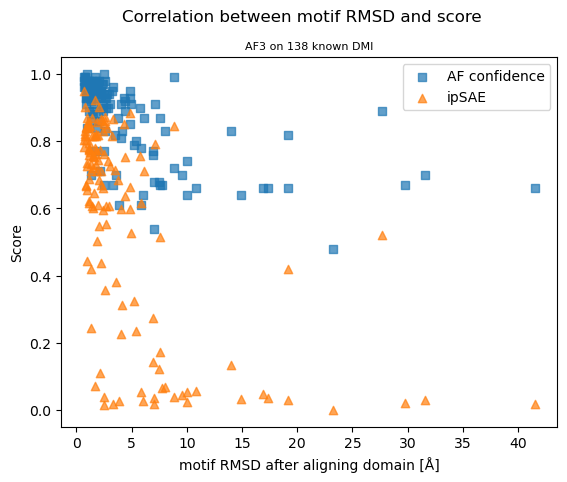

In [86]:
data = dataAF[(dataAF["benchmark_set"] == "known_DMI") & (dataAF["model_id"] == "ranked_0")]

plt.scatter(data["RMSD_all_atom_peptide_AF3"], data["ranking_score"], alpha=0.7, marker="s", label="AF confidence")
plt.scatter(data["RMSD_all_atom_peptide_AF3"], data["ipSAE"], alpha=0.7, marker="^", label="ipSAE")
plt.suptitle("Correlation between motif RMSD and score")
plt.title("AF3 on 138 known DMI", fontsize=8)
plt.legend()
plt.xlabel("motif RMSD after aligning domain [Å]")
plt.ylabel("Score")
plt.show()

In [ ]:
#plt.plot(roc_conf_X, roc_conf_Y, label=f"model confidence (AUC = {roc_conf:.2f})")
#plt.plot(roc_model_X, roc_model_Y, label=f"ml prediction (AUC = {roc_model:.2f})")
from matplotlib.axes import Axes
from matplotlib.figure import Figure

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig: Figure
axes: list[Axes] = list(axes)


    
axes[0].set_title("1 mutation in motif DMI")
axes[1].set_title("2 mutations in motif DMI")
axes[2].set_title("Randomly paired DMI")

# (display name, column name, reverse, highlight)
metric_columns = [#("ranking score", "ranking_score"), 
                  ("model confidence", "model_confidence"),
                  ("Domain chain interface pLDDDT", "chainA_intf_avg_plddt"),
                  ("Motif chain interface pLDDT", "chainB_intf_avg_plddt"),
                  ("Average interface pLDDT", "intf_avg_plddt"),
                  ("pDockQ", "pDockQ"),
                  ("iPAE", "iPAE", True),
                  ("Residue-residue contact", "num_res_res_contact"),
                  ("Atom-Atom contact", "num_atom_atom_contact"),
                  #("ipSAE", "ipSAE", False, True)
                ]

metric_columns = [[x[0], x[1] +"_AF2", x[2] if len(x) >= 3 else False, x[3] if len(x) >= 4 else False] for x in metric_columns]

rows_sets = [dataAF[dataAF["num_mutations"] == 1], dataAF[dataAF["num_mutations"] == 2], dataAF[dataAF["benchmark_set"] == "random_DMI"]]
rows_sets = [df[df["model_id"] == "ranked_0"] for df in rows_sets]
#rows_true = dataAF[dataAF["benchmark_set"] == "known_minimal"]
rows_true = dataAF[np.logical_and(dataAF["benchmark_set"] == "known_DMI", dataAF["model_id"] == "ranked_0")]



for ax, rows_false in zip(axes, rows_sets):
    y_true = [1]*len(rows_true) + [0]*len(rows_false)

    for metric_label, metric_column, reverse, highlight in metric_columns:
        y_score = rows_true[metric_column].to_list() + rows_false[metric_column].to_list()
        if reverse:
            y_score = [-y for y in y_score]
        ax.plot(*roc_curve(y_true, y_score)[0:2], label=metric_label, alpha=1) #alpha=0.2+0.8*highlight)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label="random predictor")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')


fig.tight_layout()
axes[2].legend(loc="lower right")
plt.show()


c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


KeyError: 'chainA_intf_avg_plddt'

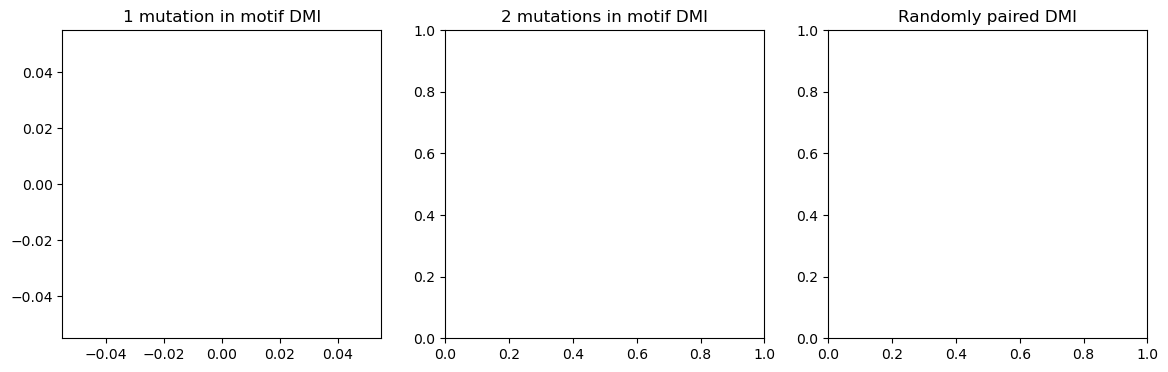

In [87]:
#plt.plot(roc_conf_X, roc_conf_Y, label=f"model confidence (AUC = {roc_conf:.2f})")
#plt.plot(roc_model_X, roc_model_Y, label=f"ml prediction (AUC = {roc_model:.2f})")
from matplotlib.axes import Axes
from matplotlib.figure import Figure


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
fig: Figure
axes: list[Axes] = list(axes)


    
axes[0].set_title("1 mutation in motif DMI")
axes[1].set_title("2 mutations in motif DMI")
axes[2].set_title("Randomly paired DMI")

# (display name, column name, reverse, highlight)
metric_columns = [("ranking score", "ranking_score"), 
                  ("Domain chain interface pLDDDT", "chainA_intf_avg_plddt"),
                  ("Motif chain interface pLDDT", "chainB_intf_avg_plddt"),
                  ("Average interface pLDDT", "intf_avg_plddt"),
                  ("pDockQ", "pDockQ"),
                  ("iPAE", "iPAE", True),
                  #("Residue-residue contact", "num_res_res_contact"),
                  #("Atom-Atom contact", "num_atom_atom_contact"),
                  ("ipSAE", "ipSAE", False, True)
                ]
metric_columns = [[x[0], x[1], x[2] if len(x) >= 3 else False, x[3] if len(x) >= 4 else False] for x in metric_columns]

rows_sets = [dataAF[dataAF["num_mutations"] == 1], dataAF[dataAF["num_mutations"] == 2], dataAF[dataAF["benchmark_set"] == "random_minimal"]]
rows_sets = [df[df["model_id"] == "ranked_0"] for df in rows_sets]
#rows_true = dataAF[dataAF["benchmark_set"] == "known_minimal"]
rows_true = dataAF[np.logical_and(dataAF["benchmark_set"] == "known_minimal", dataAF["model_id"] == "ranked_0")]



for ax, rows_false in zip(axes, rows_sets):
    y_true = [1]*len(rows_true) + [0]*len(rows_false)

    for metric_label, metric_column, reverse, highlight in metric_columns:
        y_score = rows_true[metric_column].to_list() + rows_false[metric_column].to_list()
        if reverse:
            y_score = [-y for y in y_score]
        ax.plot(*roc_curve(y_true, y_score)[0:2], label=metric_label, alpha=0.2+0.8*highlight)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label="random predictor")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')


fig.tight_layout()
axes[2].legend(loc="lower right")
plt.show()
